In [93]:
# Import necessary libraries
import pandas as pd
import unicodedata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Read the datasets
df = pd.read_csv('astr.csv', encoding='latin1')
df1 = pd.read_csv('merged_astronauts_dataset.csv', encoding='latin1')

In [95]:
df.head()

,Name,Country,Gender,Flights,Total.Flights,Total.Flight.Time,Birth.Year,Military,Selection.Group,Selection.Year,...,total_duration,nat_total_flight,first_edu,second_edu,birth_city,grad_area,Birth_Month,Birth_Day,Selection_Age,Mission_Age
0,Abdul Ahad Mohmand,Afghanistan,Male,Soyuz TM-6 (1988),1.0,008:20:26,1959.0,True,Afghanistan,1988.0,...,3780028.675,2186,NaN,NaN,NaN,Unknown / NA,NaN,NaN,29,29
1,Andreas Mogensen,Denmark,Male,Soyuz TMA-18M (2015),1.0,181:23:47,1976.0,True,ESA-3/EAC,2009.0,...,3780028.675,2186,NaN,NaN,NaN,Unknown / NA,NaN,NaN,33,39
2,Christer Fuglesang,Sweden,Male,"STS-116 (2006), STS-128 (2009)",2.0,026:17:38,1957.0,True,1992 ESA Group,1992.0,...,3780028.675,2186,NaN,NaN,NaN,Unknown / NA,NaN,NaN,35,49
3,Christer Fuglesang,Sweden,Male,"STS-116 (2006), STS-128 (2009)",2.0,026:17:38,1957.0,True,1992 ESA Group,1992.0,...,3780028.675,2186,NaN,NaN,NaN,Unknown / NA,NaN,NaN,35,52
4,Claude Nicollier,Switzerland,Male,"STS-46 (1992), STS-61 (1993), STS-75 (1996), S...",4.0,043:12:05,1944.0,True,1978 ESA Group,1978.0,...,3780028.675,2186,NaN,NaN,NaN,Unknown / NA,NaN,NaN,34,48


In [97]:
df.shape[0]

1701

In [99]:
categories = df['Mission.Role'].dropna().unique()
print (categories)

['MSP' 'flight engineer' 'PSP' 'pilot' 'Other (space tourist)'
 'Other (Journalist)' 'Other (Space tourist)' 'commander'
 'spaceflight participant' 'Pilot' 'Flight engineer']


In [101]:
# Define mapping dictionary
role_mapping = {
    'pilot': 'Pilot',
    'Pilot': 'Pilot',
    'flight engineer': 'Flight Engineer',
    'Flight engineer': 'Flight Engineer',
    'commander': 'Commander',
    'Other (space tourist)': 'Space Tourist',
    'Other (Space tourist)': 'Space Tourist',
    'spaceflight participant': 'Space Tourist',  
    'Other (Journalist)': 'Journalist'
}

# Apply mapping
df['Mission.Role.Cleaned'] = df['Mission.Role'].replace(role_mapping)

# Check new categories
print(df['Mission.Role.Cleaned'].unique())


['MSP' 'Flight Engineer' 'PSP' 'Pilot' 'Space Tourist' 'Journalist'
 'Commander' nan]


## Factor #2: Mission Age (Continued)

Average Mission_Age by Role:
Mission.Role
Flight engineer            42.500000
MSP                        42.714859
Other (Journalist)         48.000000
Other (Space tourist)      36.333333
Other (space tourist)      48.000000
PSP                        43.576271
Pilot                      37.000000
commander                  44.282540
flight engineer            43.554974
pilot                      40.271795
spaceflight participant    36.000000
Name: Mission_Age, dtype: float64


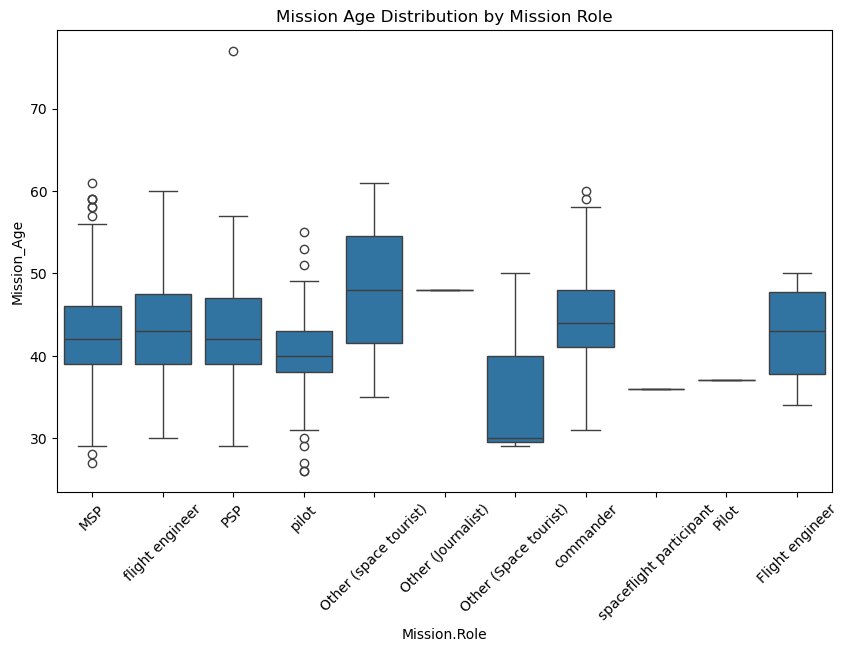


ANOVA test result:
F-statistic: 7.481, p-value: 0.00000


In [139]:
import scipy.stats as stats

# --- Clean Mission_Age ---
# Convert to numeric, force errors to NaN, then drop missing
df['Mission_Age'] = pd.to_numeric(df['Mission_Age'], errors='coerce')
df_clean = df.dropna(subset=['Mission_Age', 'Mission.Role'])

# --- 1. Descriptive Statistics ---
print("Average Mission_Age by Role:")
print(df_clean.groupby('Mission.Role')['Mission_Age'].mean())

# --- 2. Boxplot Visualization ---
plt.figure(figsize=(10,6))
sns.boxplot(x='Mission.Role', y='Mission_Age', data=df_clean)
plt.xticks(rotation=45)
plt.title("Mission Age Distribution by Mission Role")
plt.show()

# --- 3. ANOVA Test (Are mean ages different across roles?) ---
groups = [group['Mission_Age'].values for name, group in df_clean.groupby('Mission.Role')]
anova_result = stats.f_oneway(*groups)

print("\nANOVA test result:")
print(f"F-statistic: {anova_result.statistic:.3f}, p-value: {anova_result.pvalue:.5f}")


The ANOVA result yielded an F-statistic of 7.481 with a p-value < 0.001. These values indicate that the variation in Mission Age across different Mission Roles is significantly greater than would be expected by random chance. In other words, the test provides strong statistical evidence that Mission Age differs meaningfully by role. Both the high F-statistic and extremely small p-value confirm that the result is robust and statistically significant.

### What factors contribute to a longer or more active astronaut career? (Confirm the significance of Mission_Age)

In [108]:
# Clean Mission_Age: coerce non-numeric values to NaN
df["Mission_Age"] = pd.to_numeric(df["Mission_Age"], errors="coerce")

# Now aggregate per astronaut
astronauts = df.groupby("Name").agg(
    career_span=("Mission_Age", lambda x: x.max() - x.min()),
    mission_count=("Lifetime.Statistics.Mission.count", "max"),
    selection_year=("Selection.Year", "first"),
    birth_year=("Birth.Year", "first"),
    military=("Military", "first"),
    gender=("Gender", "first"),
    military_rank=("Military.Rank", "first"),
    military_branch=("Military.Branch", "first"),
    undergrad_major=("Undergraduate_Major", "first"),
    graduate_major=("Graduate_Major", "first"),
    grad_area=("grad_area", "first")
).reset_index()

# Binary target: career length (>=2 flights)
astronauts["long_career"] = (astronauts["mission_count"] >= 2).astype(int)

In [110]:
# --- Step 2: Encode categoricals ---
categorical_cols = ["military", "gender", "military_rank", "military_branch", 
                    "undergrad_major", "graduate_major", "grad_area"]

astronauts_encoded = pd.get_dummies(astronauts, columns=categorical_cols, drop_first=True)

# --- Step 3: Train models ---
X = astronauts_encoded.drop(columns=["Name", "long_career", "career_span", "mission_count"])
y = astronauts_encoded["long_career"]

X = X.dropna()
y = y.loc[X.index]  # keep y aligned with X

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train, y_train)
print("Logistic Regression Report:\n", classification_report(y_test, log_model.predict(X_test)))

# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
print("Random Forest Report:\n", classification_report(y_test, rf_model.predict(X_test)))

# Feature Importance
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top Features:\n", importances.head(10))


Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.47      0.40      0.43        40
           1       0.69      0.75      0.72        72

    accuracy                           0.62       112
   macro avg       0.58      0.57      0.58       112
weighted avg       0.61      0.62      0.62       112

Random Forest Report:
               precision    recall  f1-score   support

           0       0.50      0.40      0.44        40
           1       0.70      0.78      0.74        72

    accuracy                           0.64       112
   macro avg       0.60      0.59      0.59       112
weighted avg       0.63      0.64      0.63       112

Top Features:
 birth_year                                0.332615
selection_year                            0.311235
grad_area_Unknown / NA                    0.034894
gender_Male                               0.026275
gender_Other                              0.022588
military_rank_Colonel   

/Users/aliceyang/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Factor #3: Military (Continued)

In [113]:
from scipy.stats import chi2_contingency

# One-hot encode Military.Rank and Military.Branch
df_encoded = pd.get_dummies(df_clean, columns=['Military.Rank', 'Military.Branch'], drop_first=True)

# Keep only relevant variables
military_vars = [col for col in df_encoded.columns if 'Military' in col]

# Drop missing Mission.Role
df_military = df_encoded.dropna(subset=['Mission.Role'])

# --- Chi-Square test between Mission.Role and each military variable ---
chi2_results = {}

for var in military_vars:
    contingency_table = pd.crosstab(df_military['Mission.Role'], df_military[var])
    if contingency_table.shape[1] > 1:  # Ensure more than one category
        chi2, p, dof, ex = chi2_contingency(contingency_table)
        chi2_results[var] = {"Chi2": chi2, "p-value": p}

chi2_df = pd.DataFrame(chi2_results).T
print(chi2_df)


                                                       Chi2       p-value
Military.Rank_Captain                             54.728456  3.549142e-08
Military.Rank_Colonel                             71.175804  2.627388e-11
Military.Rank_Commander                          103.895356  9.026905e-18
Military.Rank_Lieutenant Colonel                   9.217364  5.116069e-01
Military.Rank_Lieutenant General                   1.035221  9.997983e-01
Military.Rank_Major                                7.044316  7.212547e-01
Military.Rank_Major General                        6.073056  8.090885e-01
Military.Rank_Vice Admiral                         3.277445  9.741206e-01
Military.Branch_US Air Force (Retired)            88.087067  1.281670e-14
Military.Branch_US Air Force Reserves             16.577621  8.424842e-02
Military.Branch_US Air Force Reserves (Retired)    3.982672  9.481253e-01
Military.Branch_US Army                            4.508234  9.215217e-01
Military.Branch_US Army (Retired)     

Strongest associations:
- Military Ranks of Commander, Colonel, Captain
- Branches: US Air Force (Retired), US Navy (Retired), US Army (Retired)

Interpretation: Certain ranks and retired branches strongly predict whether an astronaut serves as a Pilot, Commander, or Specialist. This reflects how military career progression translates into spaceflight mission roles.

## Factor #4: Undergraduate Discipline

In [117]:
# Clean names (basic normalization)
df1['Name_clean'] = df1['Name'].str.strip().str.upper()
df['Name_clean'] = df['Name'].str.strip().str.upper()

# Merge (mission-level output)
merged = pd.merge(df, df1, on="Name_clean", suffixes=("_df", "_df1"), how="inner")

print(merged.shape)
merged.head()


(787, 76)


,Name_df,Country_df,Gender_df,Flights,Total.Flights,Total.Flight.Time,Birth.Year,Military,Selection.Group,Selection.Year,...,Death Mission,name_key,birth_year,Country_df1,Gender_iad,Total Flights,total_flight_days,is_military,ug_discipline,pathway
0,M. Scott Carpenter,NaN,Other,NaN,NaN,NaN,1925.0,True,NASA- 1,1959.0,...,NaN,m scott carpenter,1925,NaN,NaN,NaN,NaN,True,engineering,Military
1,Virgil I. Grissom,NaN,Other,NaN,NaN,NaN,1926.0,True,NASA Astronaut Group 2,1959.0,...,Apollo 1,virgil i grissom,1926,NaN,NaN,NaN,NaN,True,engineering,Military
2,John W. Young,NaN,Other,NaN,NaN,NaN,1930.0,True,1962 NASA group 2,1962.0,...,NaN,john w young,1930,NaN,NaN,NaN,NaN,True,engineering,Military
3,John W. Young,NaN,Other,NaN,NaN,NaN,1930.0,True,1963 NASA group 2,1962.0,...,NaN,john w young,1930,NaN,NaN,NaN,NaN,True,engineering,Military
4,John W. Young,NaN,Other,NaN,NaN,NaN,1930.0,True,1964 NASA group 2,1962.0,...,NaN,john w young,1930,NaN,NaN,NaN,NaN,True,engineering,Military


In [125]:
merged.to_csv("f_merged_astronauts_dataset.csv", index=False)

In [127]:
# Define a mapping for standardization
role_map = {
    "commander": "Commander",
    "pilot": "Pilot",
    "flight engineer": "Flight Engineer",
    "Flight engineer": "Flight Engineer",
    "MSP": "Mission Specialist",
    "PSP": "Payload Specialist"
}

# Apply mapping
merged["Mission.Role.Clean"] = merged["Mission.Role"].map(role_map)

# If some roles don’t match the dictionary, keep original (optional)
merged["Mission.Role.Clean"] = merged["Mission.Role.Clean"].fillna(merged["Mission.Role"])


In [129]:
merged.head()

,Name_df,Country_df,Gender_df,Flights,Total.Flights,Total.Flight.Time,Birth.Year,Military,Selection.Group,Selection.Year,...,name_key,birth_year,Country_df1,Gender_iad,Total Flights,total_flight_days,is_military,ug_discipline,pathway,Mission.Role.Clean
0,M. Scott Carpenter,NaN,Other,NaN,NaN,NaN,1925.0,True,NASA- 1,1959.0,...,m scott carpenter,1925,NaN,NaN,NaN,NaN,True,engineering,Military,Pilot
1,Virgil I. Grissom,NaN,Other,NaN,NaN,NaN,1926.0,True,NASA Astronaut Group 2,1959.0,...,virgil i grissom,1926,NaN,NaN,NaN,NaN,True,engineering,Military,Commander
2,John W. Young,NaN,Other,NaN,NaN,NaN,1930.0,True,1962 NASA group 2,1962.0,...,john w young,1930,NaN,NaN,NaN,NaN,True,engineering,Military,Pilot
3,John W. Young,NaN,Other,NaN,NaN,NaN,1930.0,True,1963 NASA group 2,1962.0,...,john w young,1930,NaN,NaN,NaN,NaN,True,engineering,Military,Pilot
4,John W. Young,NaN,Other,NaN,NaN,NaN,1930.0,True,1964 NASA group 2,1962.0,...,john w young,1930,NaN,NaN,NaN,NaN,True,engineering,Military,Pilot


In [137]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df_model_clean = merged.dropna(subset=["Mission.Role.Clean"])

# Features and target
X = df_model_clean[['is_military', 'Mission_Age', 'ug_discipline']]
y = df_model_clean['Mission.Role.Clean']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessing: scale numeric, encode categorical
numeric_features = ['Mission_Age']
categorical_features = ['is_military', 'ug_discipline']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# ---------------- Logistic Regression ----------------
log_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=2000, solver='saga'))
])

log_clf.fit(X_train, y_train)
y_pred_log = log_clf.predict(X_test)

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_log))

# ---------------- Random Forest ----------------
rf_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(random_state=42, n_estimators=300))
])

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))


=== Logistic Regression ===
                    precision    recall  f1-score   support

         Commander       0.52      0.63      0.57        27
   Flight Engineer       0.00      0.00      0.00         7
Mission Specialist       0.74      0.80      0.77        74
             Pilot       0.50      0.41      0.45        27

          accuracy                           0.64       135
         macro avg       0.44      0.46      0.45       135
      weighted avg       0.61      0.64      0.62       135

=== Random Forest ===
                    precision    recall  f1-score   support

         Commander       0.51      0.67      0.58        27
   Flight Engineer       0.00      0.00      0.00         7
Mission Specialist       0.80      0.81      0.81        74
             Pilot       0.55      0.44      0.49        27

          accuracy                           0.67       135
         macro avg       0.46      0.48      0.47       135
      weighted avg       0.65      0.67      

/Users/aliceyang/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliceyang/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aliceyang/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Analysis of Four Factors and Mission Role Outcomes (Foundation for OpenAI API Prompts)

### Gender

In [146]:
# Clean and filter relevant columns
df_gender_role = merged[['Gender_df1', 'Mission.Role.Clean']].dropna()

# Compute conditional probabilities: P(Mission.Role | Gender)
conditional_probs = (
    df_gender_role
    .groupby('Gender_df1')['Mission.Role.Clean']
    .value_counts(normalize=True)
    .rename("P(MissionRole | Gender)")
    .reset_index()
)

# Pivot to table format (optional, if you want to print as matrix)
pivot_table = conditional_probs.pivot(index='Gender_df1', columns='Mission.Role.Clean', values='P(MissionRole | Gender)')

# Display the probability table
print(pivot_table)

Mission.Role.Clean  Commander  Flight Engineer  Mission Specialist     Pilot
Gender_df1                                                                  
Female               0.027273         0.081818            0.854545  0.036364
Male                 0.234458         0.049734            0.488455  0.227353


### Mission Age

In [171]:
# Drop missing values
df_age_role = merged[['Mission_Age', 'Mission.Role.Clean']].dropna()

# --- Step 1: Bin Mission_Age into age groups ---
age_bins = [20, 30, 40, 50, 60, 70, 80]
age_labels = ['20–29', '30–39', '40–49', '50–59', '60–69', '70–79']
df_age_role['AgeGroup'] = pd.cut(df_age_role['Mission_Age'], bins=age_bins, labels=age_labels)

# --- Step 2: Calculate conditional probabilities P(Mission.Role | AgeGroup) ---
role_probs_by_age = (
    df_age_role
    .groupby('AgeGroup')['Mission.Role.Clean']
    .value_counts(normalize=True)
    .rename("P(MissionRole | AgeGroup)")
    .reset_index()
)

# --- Step 3: Pivot to table format (optional) ---
pivot_table = role_probs_by_age.pivot(index='AgeGroup', columns='Mission.Role.Clean', values='P(MissionRole | AgeGroup)')

# Display the result
print(pivot_table)


Mission.Role.Clean  Commander  Flight Engineer  Mission Specialist     Pilot
AgeGroup                                                                    
20–29                0.000000         0.000000            0.000000  0.000000
30–39                0.068966         0.017241            0.659483  0.254310
40–49                0.269333         0.050667            0.490667  0.189333
50–59                0.272727         0.212121            0.484848  0.030303
60–69                0.000000         0.000000            0.000000  0.000000
70–79                0.000000         0.000000            0.000000  0.000000


/var/folders/68/v45nchbs4w34j3yzyhpsgs7w0000gn/T/ipykernel_83554/4002742361.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('AgeGroup')['Mission.Role.Clean']


### Military

In [178]:
# Filter only military personnel with complete role, rank, and branch data
df_military = merged[
    (merged['is_military'] == True) &
    merged['Mission.Role.Clean'].notna() &
    merged['Military.Rank'].notna() &
    merged['Military.Branch'].notna()
][['Military.Rank', 'Military.Branch', 'Mission.Role.Clean']]

# ---- Pivot Table 1: Military.Rank vs Mission Role ----
rank_role_probs = (
    df_military
    .groupby(['Military.Rank', 'Mission.Role.Clean'])
    .size()
    .groupby(level=0, group_keys=False)
    .apply(lambda x: x / x.sum())  # normalize within each rank
    .rename("P(MissionRole | Military.Rank)")
    .reset_index()
)

pivot_rank = rank_role_probs.pivot(index='Military.Rank', columns='Mission.Role.Clean', values='P(MissionRole | Military.Rank)')
print("\nPivot Table: Military.Rank vs Mission.Role.Clean")
print(pivot_rank)

# ---- Pivot Table 2: Military.Branch vs Mission Role ----
branch_role_probs = (
    df_military
    .groupby(['Military.Branch', 'Mission.Role.Clean'])
    .size()
    .groupby(level=0, group_keys=False)
    .apply(lambda x: x / x.sum())  # normalize within each branch
    .rename("P(MissionRole | Military.Branch)")
    .reset_index()
)

pivot_branch = branch_role_probs.pivot(index='Military.Branch', columns='Mission.Role.Clean', values='P(MissionRole | Military.Branch)')
print("\nPivot Table: Military.Branch vs Mission.Role.Clean")
print(pivot_branch)



Pivot Table: Military.Rank vs Mission.Role.Clean
Mission.Role.Clean  Commander  Flight Engineer  Mission Specialist     Pilot
Military.Rank                                                               
Brigadier General    0.428571              NaN            0.285714  0.285714
Captain              0.367347         0.054422            0.285714  0.292517
Colonel              0.263682         0.044776            0.378109  0.313433
Commander                 NaN         0.076923            0.538462  0.384615
Lieutenant Colonel   0.111111              NaN            0.666667  0.222222
Lieutenant General   0.333333         0.111111            0.444444  0.111111
Major                0.333333              NaN                 NaN  0.666667
Major General        1.000000              NaN                 NaN       NaN
Vice Admiral         0.500000              NaN                 NaN  0.500000

Pivot Table: Military.Branch vs Mission.Role.Clean
Mission.Role.Clean               Commander  Flight 

### Undergraduate Discipline

In [181]:
# Filter rows with non-null ug_discipline and Mission.Role.Clean
df_ug = merged[['ug_discipline', 'Mission.Role.Clean']].dropna()

# Group and calculate P(Mission.Role | ug_discipline)
ug_role_probs = (
    df_ug
    .groupby(['ug_discipline', 'Mission.Role.Clean'])
    .size()
    .groupby(level=0, group_keys=False)
    .apply(lambda x: x / x.sum())
    .rename("P(MissionRole | ug_discipline)")
    .reset_index()
)

# Pivot into a role-by-discipline table
pivot_ug = ug_role_probs.pivot(index='ug_discipline', columns='Mission.Role.Clean', values='P(MissionRole | ug_discipline)')

# Display the pivot table
print("\nPivot Table: ug_discipline vs Mission.Role.Clean")
print(pivot_ug)


Pivot Table: ug_discipline vs Mission.Role.Clean
Mission.Role.Clean  Commander  Flight Engineer  Mission Specialist     Pilot
ug_discipline                                                               
engineering          0.248768         0.041872            0.472906  0.236453
life_sciences             NaN         0.062500            0.937500       NaN
math                 0.225000         0.075000            0.425000  0.275000
other/unknown        0.182796         0.086022            0.516129  0.215054
physical_sciences    0.067797         0.067797            0.822034  0.042373
